# Data Augmentation



In [1]:
import numpy as np
from mlp.layers import Layer
#define different activation function layer
class TanhLayer(Layer):
    """Layer implementing an element-wise hyperbolic tangent transformation."""

    def fprop(self, inputs):
        """Forward propagates activations through the layer transformation.

        For inputs `x` and outputs `y` this corresponds to `y = tanh(x)`.
        """
        return np.tanh(inputs)

    def bprop(self, inputs, outputs, grads_wrt_outputs):
        """Back propagates gradients through a layer.

        Given gradients with respect to the outputs of the layer calculates the
        gradients with respect to the layer inputs.
        """
        return (1. - outputs**2) * grads_wrt_outputs

    def __repr__(self):
        return 'TanhLayer'
    

class ReluLayer(Layer):
    """Layer implementing an element-wise rectified linear transformation."""

    def fprop(self, inputs):
        """Forward propagates activations through the layer transformation.

        For inputs `x` and outputs `y` this corresponds to `y = max(0, x)`.
        """
        return np.maximum(inputs, 0.)

    def bprop(self, inputs, outputs, grads_wrt_outputs):
        """Back propagates gradients through a layer.

        Given gradients with respect to the outputs of the layer calculates the
        gradients with respect to the layer inputs.
        """
        return (outputs > 0) * grads_wrt_outputs

    def __repr__(self):
        return 'ReluLayer'

In [2]:
#initial parameters
import numpy as np
from collections import OrderedDict
import logging
from mlp.layers import AffineLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import GlorotUniformInit, ConstantInit
from mlp.learning_rules import MomentumLearningRule
from mlp.data_providers import MNISTDataProvider
from mlp.optimisers import Optimiser

# Seed a random number generator
seed = 24102016 
rng = np.random.RandomState(seed)

num_epochs = 100
stats_interval = 5
batch_size = 50
learning_rate = 0.01
mom_coeff = 0.9
weights_init_gain = 0.5
biases_init = 0.

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', batch_size, rng=rng)
valid_data = MNISTDataProvider('valid', batch_size, rng=rng)
input_dim, output_dim, hidden_dim = 784, 10, 100

weights_init = GlorotUniformInit(weights_init_gain, rng)
biases_init = ConstantInit(biases_init)
error = CrossEntropySoftmaxError()
learning_rule = MomentumLearningRule(learning_rate, mom_coeff)
data_monitors = {'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

In [26]:
#train a network without any data argumentation
weights_penalty = None

run_info = OrderedDict()
models = OrderedDict()

rng.seed(seed)
train_data.reset()
valid_data.reset()
print('Regularisation: {0}'.format(weights_penalty))
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, 
                biases_init, weights_penalty),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, 
                biases_init, weights_penalty),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, 
                biases_init, weights_penalty)
])
optimiser = Optimiser(model, error, learning_rule, train_data, valid_data, data_monitors)
run_info[weights_penalty] = optimiser.train(num_epochs, stats_interval)
models[weights_penalty] = model

Regularisation: None


Epoch 5: 1.10s to complete
  error(train)=6.34e-02, acc(train)=9.82e-01, error(valid)=9.67e-02, acc(valid)=9.72e-01, params_penalty=0.00e+00
Epoch 10: 1.14s to complete
  error(train)=2.36e-02, acc(train)=9.94e-01, error(valid)=8.34e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 15: 1.20s to complete
  error(train)=8.49e-03, acc(train)=9.98e-01, error(valid)=8.34e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 20: 1.19s to complete
  error(train)=3.42e-03, acc(train)=1.00e+00, error(valid)=9.58e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 25: 1.20s to complete
  error(train)=1.42e-03, acc(train)=1.00e+00, error(valid)=9.48e-02, acc(valid)=9.79e-01, params_penalty=0.00e+00
Epoch 30: 1.19s to complete
  error(train)=9.06e-04, acc(train)=1.00e+00, error(valid)=1.01e-01, acc(valid)=9.79e-01, params_penalty=0.00e+00
Epoch 35: 1.19s to complete
  error(train)=6.40e-04, acc(train)=1.00e+00, error(valid)=1.04e-01, acc(valid)=9.79e-01, params_penalty=0.00e+00
Epoch 4

In [32]:
#define different data argumentation method
#start with rotation
from scipy.ndimage.interpolation import rotate, shift,zoom

def random_rotation(inputs, rng):
    """Randomly rotates a subset of images in a batch.
    
    Args:
        inputs: Input image batch, an array of shape (batch_size, 784).
        rng: A seeded random number generator.
        
    Returns:
        An array of shape (batch_size, 784) corresponding to a copy
        of the original `inputs` array with the randomly selected
        images rotated by a random angle. The original `inputs`
        array should not be modified.
    """
    orig_ims = inputs.reshape((-1, 28, 28))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    angles = rng.uniform(-1., 1., size=indices.shape[0]) * 30.
    for i, j in enumerate(indices):
        new_ims[j] = rotate(orig_ims[j], angles[i], order=1, reshape=False)
    return new_ims.reshape((-1, 784))

def random_shift(inputs, rng):
    orig_ims = inputs
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    for i, j in enumerate(indices):
        new_ims[j] = shift(orig_ims[j],shift=2.0 ,order=1)
    return new_ims.reshape((-1, 784))

# #problem
# def random_zoom(inputs, rng):
#     orig_ims = inputs.reshape((-1, 28, 28))
#     new_ims = orig_ims.copy()
#     indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
# #     angles = rng.uniform(-1., 1., size=indices.shape[0]) * 30.
#     for i, j in enumerate(indices):
#         new_ims[j] = zoom(orig_ims[j],1.2,order=1)[:28,:28]
#     return new_ims.reshape((-1, 784))

def random_flip(inputs, rng):
    orig_ims = inputs.reshape((-1, 28, 28))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    for j in (indices):
        new_ims[j] = np.fliplr(orig_ims[j])
    return new_ims.reshape((-1, 784))

def random_Gaussian(inputs, rng):
    orig_ims = inputs.reshape((-1, 28, 28))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    for j in (indices):
        new_ims[j] = orig_ims[j]*np.random.normal(0,0.8)
    return new_ims.reshape((-1, 784))

In [59]:

# def shift_zoom(inputs, rng):
#     orig_ims = inputs
#     new_ims = orig_ims.copy()
#     indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
#     for i, j in enumerate(indices):
#         new_ims[j] = shift(orig_ims[j],22.0 ,order=1)
#         new_ims[j] = zoom(new_ims[j],1.0 ,order=1)
#     return new_ims.reshape((-1, 784))

# def zoom_shift(inputs, rng):
#     orig_ims = inputs
#     new_ims = orig_ims.copy()
#     indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
#     for i, j in enumerate(indices):
#         new_ims[j] = zoom(orig_ims[j],1.0 ,order=1)
#         new_ims[j] = shift(new_ims[j],22.0 ,order=1)
#     return new_ims.reshape((-1, 784))


def Gaussian_flip(inputs, rng):
    orig_ims = inputs.reshape((-1, 28, 28))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    for j in (indices):
        new_ims[j] = np.fliplr(orig_ims[j])
        new_ims[j] = new_ims[j]*np.random.normal(0,0.8)
    return new_ims.reshape((-1, 784))

def flip_Gaussian(inputs, rng):
    orig_ims = inputs.reshape((-1, 28, 28))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    for j in (indices):
        new_ims[j] = orig_ims[j]*np.random.normal(0,0.8)
        new_ims[j] = np.fliplr(new_ims[j])
    return new_ims.reshape((-1, 784))

def Gaussian_rotation(inputs, rng):
    orig_ims = inputs.reshape((-1, 28, 28))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    for j in (indices):
        new_ims[j] = np.fliplr(orig_ims[j])
    angles = rng.uniform(-1., 1., size=indices.shape[0]) * 30.
    for i, j in enumerate(indices):
        new_ims[j] = rotate(new_ims[j], angles[i], order=1, reshape=False)
    return new_ims.reshape((-1, 784))

def rotation_Gaussian(inputs, rng):
    orig_ims = inputs.reshape((-1, 28, 28))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    angles = rng.uniform(-1., 1., size=indices.shape[0]) * 30.
    for i, j in enumerate(indices):
        new_ims[j] = rotate(orig_ims[j], angles[i], order=1, reshape=False)
    for j in (indices):
        new_ims[j] = np.fliplr(new_ims[j])
    return new_ims.reshape((-1, 784))

def comb_rotation_shift_Gaussian(inputs, rng):
    orig_ims = inputs.reshape((-1, 28, 28))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    angles = rng.uniform(-1., 1., size=indices.shape[0]) * 30.
    for i, j in enumerate(indices):
        new_ims[j] = rotate(orig_ims[j], angles[i], order=1, reshape=False)
        new_ims[j] = shift(new_ims[j],shift=2.0 ,order=1)
    for j in (indices):
        new_ims[j] = new_ims[j]*np.random.normal(0,0.8)
    return new_ims.reshape((-1, 784))



In [60]:
from mlp.data_providers import AugmentedMNISTDataProvider

aug_train_data1 = AugmentedMNISTDataProvider('train', rng=rng, transformer=random_rotation)
aug_train_data2 = AugmentedMNISTDataProvider('train', rng=rng, transformer=random_shift)
aug_train_data3 = AugmentedMNISTDataProvider('train', rng=rng, transformer=random_flip)
aug_train_data4 = AugmentedMNISTDataProvider('train', rng=rng, transformer=random_Gaussian)
aug_train_data5 = AugmentedMNISTDataProvider('train', rng=rng, transformer=Gaussian_flip)
aug_train_data6 = AugmentedMNISTDataProvider('train', rng=rng, transformer=flip_Gaussian)
aug_train_data7 = AugmentedMNISTDataProvider('train', rng=rng, transformer=comb_rotation_shift_Gaussian)
aug_train_data8 = AugmentedMNISTDataProvider('train', rng=rng, transformer=Gaussian_rotation)
aug_train_data9 = AugmentedMNISTDataProvider('train', rng=rng, transformer=rotation_Gaussian)

In [34]:
aug_train_data1 = AugmentedMNISTDataProvider('train', rng=rng, transformer=random_rotation)
batch_size = 100
num_epochs = 100
learning_rate = 0.01
mom_coeff = 0.9
stats_interval = 5

rng.seed(seed)
aug_train_data1.reset()
valid_data.reset()
aug_train_data1.batch_size = batch_size 
valid_data.batch_size = batch_size

weights_init = GlorotUniformInit(0.5, rng=rng)
biases_init = ConstantInit(0.)

model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
learning_rule = MomentumLearningRule(learning_rate=learning_rate, mom_coeff=mom_coeff)
data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
optimiser = Optimiser(
    model, error, learning_rule, aug_train_data1, valid_data, data_monitors)

aug_stats1, aug_keys1, aug_run_time1 = optimiser.train(
    num_epochs=num_epochs, stats_interval=stats_interval)

Epoch 5: 2.19s to complete
  error(train)=1.45e-01, acc(train)=9.57e-01, error(valid)=1.23e-01, acc(valid)=9.65e-01, params_penalty=0.00e+00
Epoch 10: 2.18s to complete
  error(train)=8.53e-02, acc(train)=9.74e-01, error(valid)=8.48e-02, acc(valid)=9.74e-01, params_penalty=0.00e+00
Epoch 15: 2.18s to complete
  error(train)=6.26e-02, acc(train)=9.81e-01, error(valid)=7.69e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 20: 2.19s to complete
  error(train)=5.26e-02, acc(train)=9.85e-01, error(valid)=7.79e-02, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 25: 2.19s to complete
  error(train)=4.33e-02, acc(train)=9.88e-01, error(valid)=7.29e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 30: 2.21s to complete
  error(train)=3.72e-02, acc(train)=9.89e-01, error(valid)=7.23e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 35: 2.23s to complete
  error(train)=3.56e-02, acc(train)=9.90e-01, error(valid)=7.50e-02, acc(valid)=9.79e-01, params_penalty=0.00e+00
Epoch 4

In [22]:
batch_size = 100
num_epochs = 100
learning_rate = 0.01
mom_coeff = 0.9
stats_interval = 5

rng.seed(seed)
aug_train_data2.reset()
valid_data.reset()
aug_train_data2.batch_size = batch_size 
valid_data.batch_size = batch_size

weights_init = GlorotUniformInit(0.5, rng=rng)
biases_init = ConstantInit(0.)

model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
learning_rule = MomentumLearningRule(learning_rate=learning_rate, mom_coeff=mom_coeff)
data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
optimiser = Optimiser(
    model, error, learning_rule, aug_train_data2, valid_data, data_monitors)

aug_stats2, aug_keys2, aug_run_time2 = optimiser.train(
    num_epochs=num_epochs, stats_interval=stats_interval)

Epoch 5: 2.97s to complete
  error(train)=1.43e-01, acc(train)=9.57e-01, error(valid)=1.40e-01, acc(valid)=9.59e-01, params_penalty=0.00e+00
Epoch 10: 2.56s to complete
  error(train)=7.26e-02, acc(train)=9.79e-01, error(valid)=9.09e-02, acc(valid)=9.74e-01, params_penalty=0.00e+00
Epoch 15: 2.21s to complete
  error(train)=5.65e-02, acc(train)=9.83e-01, error(valid)=8.60e-02, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 20: 2.21s to complete
  error(train)=3.90e-02, acc(train)=9.89e-01, error(valid)=8.09e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 25: 2.21s to complete
  error(train)=3.13e-02, acc(train)=9.91e-01, error(valid)=7.90e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 30: 2.20s to complete
  error(train)=2.51e-02, acc(train)=9.93e-01, error(valid)=8.02e-02, acc(valid)=9.79e-01, params_penalty=0.00e+00
Epoch 35: 2.21s to complete
  error(train)=1.75e-02, acc(train)=9.96e-01, error(valid)=7.77e-02, acc(valid)=9.79e-01, params_penalty=0.00e+00
Epoch 4

In [10]:
batch_size = 100
num_epochs = 100
learning_rate = 0.01
mom_coeff = 0.9
stats_interval = 5

rng.seed(seed)
aug_train_data3.reset()
valid_data.reset()
aug_train_data3.batch_size = batch_size 
valid_data.batch_size = batch_size

weights_init = GlorotUniformInit(0.5, rng=rng)
biases_init = ConstantInit(0.)

model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
learning_rule = MomentumLearningRule(learning_rate=learning_rate, mom_coeff=mom_coeff)
data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
optimiser = Optimiser(
    model, error, learning_rule, aug_train_data3, valid_data, data_monitors)

aug_stats3, aug_keys3, aug_run_time3 = optimiser.train(
    num_epochs=num_epochs, stats_interval=stats_interval)

Epoch 5: 0.96s to complete
  error(train)=1.94e-01, acc(train)=9.41e-01, error(valid)=1.69e-01, acc(valid)=9.51e-01, params_penalty=0.00e+00
Epoch 10: 0.98s to complete
  error(train)=1.19e-01, acc(train)=9.63e-01, error(valid)=1.23e-01, acc(valid)=9.64e-01, params_penalty=0.00e+00
Epoch 15: 0.98s to complete
  error(train)=8.46e-02, acc(train)=9.75e-01, error(valid)=1.13e-01, acc(valid)=9.69e-01, params_penalty=0.00e+00
Epoch 20: 0.96s to complete
  error(train)=6.56e-02, acc(train)=9.80e-01, error(valid)=1.09e-01, acc(valid)=9.68e-01, params_penalty=0.00e+00
Epoch 25: 0.99s to complete
  error(train)=5.15e-02, acc(train)=9.84e-01, error(valid)=1.02e-01, acc(valid)=9.71e-01, params_penalty=0.00e+00
Epoch 30: 0.99s to complete
  error(train)=4.07e-02, acc(train)=9.88e-01, error(valid)=1.10e-01, acc(valid)=9.69e-01, params_penalty=0.00e+00
Epoch 35: 0.99s to complete
  error(train)=3.37e-02, acc(train)=9.90e-01, error(valid)=1.11e-01, acc(valid)=9.71e-01, params_penalty=0.00e+00
Epoch 4

In [11]:
batch_size = 100
num_epochs = 100
learning_rate = 0.01
mom_coeff = 0.9
stats_interval = 5

rng.seed(seed)
aug_train_data4.reset()
valid_data.reset()
aug_train_data4.batch_size = batch_size 
valid_data.batch_size = batch_size

weights_init = GlorotUniformInit(0.5, rng=rng)
biases_init = ConstantInit(0.)

model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
learning_rule = MomentumLearningRule(learning_rate=learning_rate, mom_coeff=mom_coeff)
data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
optimiser = Optimiser(
    model, error, learning_rule, aug_train_data4, valid_data, data_monitors)

aug_stats4, aug_keys4, aug_run_time4 = optimiser.train(
    num_epochs=num_epochs, stats_interval=stats_interval)

Epoch 5: 0.97s to complete
  error(train)=2.33e-01, acc(train)=9.42e-01, error(valid)=1.62e-01, acc(valid)=9.55e-01, params_penalty=0.00e+00
Epoch 10: 0.97s to complete
  error(train)=1.36e-01, acc(train)=9.69e-01, error(valid)=1.11e-01, acc(valid)=9.69e-01, params_penalty=0.00e+00
Epoch 15: 0.98s to complete
  error(train)=1.01e-01, acc(train)=9.77e-01, error(valid)=1.02e-01, acc(valid)=9.74e-01, params_penalty=0.00e+00
Epoch 20: 0.98s to complete
  error(train)=7.11e-02, acc(train)=9.86e-01, error(valid)=9.75e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 25: 0.98s to complete
  error(train)=5.95e-02, acc(train)=9.89e-01, error(valid)=1.17e-01, acc(valid)=9.75e-01, params_penalty=0.00e+00
Epoch 30: 0.98s to complete
  error(train)=5.23e-02, acc(train)=9.91e-01, error(valid)=1.17e-01, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 35: 0.98s to complete
  error(train)=4.57e-02, acc(train)=9.91e-01, error(valid)=1.29e-01, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 4

In [12]:
batch_size = 100
num_epochs = 100
learning_rate = 0.01
mom_coeff = 0.9
stats_interval = 5

rng.seed(seed)
aug_train_data5.reset()
valid_data.reset()
aug_train_data5.batch_size = batch_size 
valid_data.batch_size = batch_size

weights_init = GlorotUniformInit(0.5, rng=rng)
biases_init = ConstantInit(0.)

model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
learning_rule = MomentumLearningRule(learning_rate=learning_rate, mom_coeff=mom_coeff)
data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
optimiser = Optimiser(
    model, error, learning_rule, aug_train_data5, valid_data, data_monitors)

aug_stats5, aug_keys5, aug_run_time5 = optimiser.train(
    num_epochs=num_epochs, stats_interval=stats_interval)

Epoch 5: 2.70s to complete
  error(train)=3.02e-01, acc(train)=9.18e-01, error(valid)=1.84e-01, acc(valid)=9.45e-01, params_penalty=0.00e+00
Epoch 10: 1.04s to complete
  error(train)=1.95e-01, acc(train)=9.51e-01, error(valid)=1.30e-01, acc(valid)=9.62e-01, params_penalty=0.00e+00
Epoch 15: 1.05s to complete
  error(train)=1.49e-01, acc(train)=9.64e-01, error(valid)=1.12e-01, acc(valid)=9.67e-01, params_penalty=0.00e+00
Epoch 20: 1.05s to complete
  error(train)=1.22e-01, acc(train)=9.70e-01, error(valid)=1.22e-01, acc(valid)=9.67e-01, params_penalty=0.00e+00
Epoch 25: 1.06s to complete
  error(train)=1.07e-01, acc(train)=9.73e-01, error(valid)=1.12e-01, acc(valid)=9.69e-01, params_penalty=0.00e+00
Epoch 30: 1.05s to complete
  error(train)=9.54e-02, acc(train)=9.77e-01, error(valid)=1.14e-01, acc(valid)=9.68e-01, params_penalty=0.00e+00
Epoch 35: 1.05s to complete
  error(train)=8.48e-02, acc(train)=9.79e-01, error(valid)=1.28e-01, acc(valid)=9.69e-01, params_penalty=0.00e+00
Epoch 4

In [13]:
batch_size = 100
num_epochs = 100
learning_rate = 0.01
mom_coeff = 0.9
stats_interval = 5

rng.seed(seed)
aug_train_data6.reset()
valid_data.reset()
aug_train_data6.batch_size = batch_size 
valid_data.batch_size = batch_size

weights_init = GlorotUniformInit(0.5, rng=rng)
biases_init = ConstantInit(0.)

model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
learning_rule = MomentumLearningRule(learning_rate=learning_rate, mom_coeff=mom_coeff)
data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
optimiser = Optimiser(
    model, error, learning_rule, aug_train_data6, valid_data, data_monitors)

aug_stats6, aug_keys6, aug_run_time6 = optimiser.train(
    num_epochs=num_epochs, stats_interval=stats_interval)

Epoch 5: 1.03s to complete
  error(train)=3.07e-01, acc(train)=9.19e-01, error(valid)=1.89e-01, acc(valid)=9.44e-01, params_penalty=0.00e+00
Epoch 10: 1.04s to complete
  error(train)=2.07e-01, acc(train)=9.48e-01, error(valid)=1.34e-01, acc(valid)=9.62e-01, params_penalty=0.00e+00
Epoch 15: 1.04s to complete
  error(train)=1.53e-01, acc(train)=9.62e-01, error(valid)=1.14e-01, acc(valid)=9.67e-01, params_penalty=0.00e+00
Epoch 20: 1.05s to complete
  error(train)=1.27e-01, acc(train)=9.68e-01, error(valid)=1.21e-01, acc(valid)=9.66e-01, params_penalty=0.00e+00
Epoch 25: 1.05s to complete
  error(train)=1.03e-01, acc(train)=9.76e-01, error(valid)=1.15e-01, acc(valid)=9.69e-01, params_penalty=0.00e+00
Epoch 30: 1.05s to complete
  error(train)=9.42e-02, acc(train)=9.76e-01, error(valid)=1.17e-01, acc(valid)=9.68e-01, params_penalty=0.00e+00
Epoch 35: 1.05s to complete
  error(train)=8.29e-02, acc(train)=9.81e-01, error(valid)=1.32e-01, acc(valid)=9.68e-01, params_penalty=0.00e+00
Epoch 4

In [23]:
batch_size = 100
num_epochs = 100
learning_rate = 0.01
mom_coeff = 0.9
stats_interval = 5

rng.seed(seed)
aug_train_data7.reset()
valid_data.reset()
aug_train_data7.batch_size = batch_size 
valid_data.batch_size = batch_size

weights_init = GlorotUniformInit(0.5, rng=rng)
biases_init = ConstantInit(0.)

model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
learning_rule = MomentumLearningRule(learning_rate=learning_rate, mom_coeff=mom_coeff)
data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
optimiser = Optimiser(
    model, error, learning_rule, aug_train_data7, valid_data, data_monitors)

aug_stats7, aug_keys7, aug_run_time7 = optimiser.train(
    num_epochs=num_epochs, stats_interval=stats_interval)

Epoch 5: 3.04s to complete
  error(train)=2.88e-01, acc(train)=9.23e-01, error(valid)=1.65e-01, acc(valid)=9.52e-01, params_penalty=0.00e+00
Epoch 10: 2.83s to complete
  error(train)=1.90e-01, acc(train)=9.54e-01, error(valid)=1.13e-01, acc(valid)=9.65e-01, params_penalty=0.00e+00
Epoch 15: 2.83s to complete
  error(train)=1.51e-01, acc(train)=9.64e-01, error(valid)=9.80e-02, acc(valid)=9.71e-01, params_penalty=0.00e+00
Epoch 20: 2.90s to complete
  error(train)=1.24e-01, acc(train)=9.71e-01, error(valid)=9.43e-02, acc(valid)=9.73e-01, params_penalty=0.00e+00
Epoch 25: 2.92s to complete
  error(train)=1.03e-01, acc(train)=9.77e-01, error(valid)=9.18e-02, acc(valid)=9.73e-01, params_penalty=0.00e+00
Epoch 30: 3.39s to complete
  error(train)=9.22e-02, acc(train)=9.77e-01, error(valid)=9.69e-02, acc(valid)=9.74e-01, params_penalty=0.00e+00
Epoch 35: 3.16s to complete
  error(train)=7.98e-02, acc(train)=9.81e-01, error(valid)=1.07e-01, acc(valid)=9.75e-01, params_penalty=0.00e+00
Epoch 4

In [24]:
batch_size = 100
num_epochs = 100
learning_rate = 0.01
mom_coeff = 0.9
stats_interval = 5

rng.seed(seed)
aug_train_data8.reset()
valid_data.reset()
aug_train_data8.batch_size = batch_size 
valid_data.batch_size = batch_size

weights_init = GlorotUniformInit(0.5, rng=rng)
biases_init = ConstantInit(0.)

model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
learning_rule = MomentumLearningRule(learning_rate=learning_rate, mom_coeff=mom_coeff)
data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
optimiser = Optimiser(
    model, error, learning_rule, aug_train_data8, valid_data, data_monitors)

aug_stats8, aug_keys8, aug_run_time8 = optimiser.train(
    num_epochs=num_epochs, stats_interval=stats_interval)

Epoch 5: 2.24s to complete
  error(train)=2.26e-01, acc(train)=9.31e-01, error(valid)=1.68e-01, acc(valid)=9.52e-01, params_penalty=0.00e+00
Epoch 10: 2.25s to complete
  error(train)=1.41e-01, acc(train)=9.56e-01, error(valid)=1.28e-01, acc(valid)=9.64e-01, params_penalty=0.00e+00
Epoch 15: 2.27s to complete
  error(train)=1.14e-01, acc(train)=9.65e-01, error(valid)=1.18e-01, acc(valid)=9.67e-01, params_penalty=0.00e+00
Epoch 20: 2.25s to complete
  error(train)=9.17e-02, acc(train)=9.73e-01, error(valid)=1.11e-01, acc(valid)=9.69e-01, params_penalty=0.00e+00
Epoch 25: 2.26s to complete
  error(train)=7.47e-02, acc(train)=9.78e-01, error(valid)=1.05e-01, acc(valid)=9.69e-01, params_penalty=0.00e+00
Epoch 30: 2.26s to complete
  error(train)=7.13e-02, acc(train)=9.79e-01, error(valid)=1.15e-01, acc(valid)=9.70e-01, params_penalty=0.00e+00
Epoch 35: 2.26s to complete
  error(train)=6.20e-02, acc(train)=9.82e-01, error(valid)=1.14e-01, acc(valid)=9.67e-01, params_penalty=0.00e+00
Epoch 4

In [61]:
batch_size = 100
num_epochs = 100
learning_rate = 0.01
mom_coeff = 0.9
stats_interval = 5

rng.seed(seed)
aug_train_data9.reset()
valid_data.reset()
aug_train_data9.batch_size = batch_size 
valid_data.batch_size = batch_size

weights_init = GlorotUniformInit(0.5, rng=rng)
biases_init = ConstantInit(0.)

model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
learning_rule = MomentumLearningRule(learning_rate=learning_rate, mom_coeff=mom_coeff)
data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
optimiser = Optimiser(
    model, error, learning_rule, aug_train_data9, valid_data, data_monitors)

aug_stats9, aug_keys9, aug_run_time9 = optimiser.train(
    num_epochs=num_epochs, stats_interval=stats_interval)

Epoch 5: 2.72s to complete
  error(train)=2.19e-01, acc(train)=9.33e-01, error(valid)=1.68e-01, acc(valid)=9.52e-01, params_penalty=0.00e+00
Epoch 10: 2.45s to complete
  error(train)=1.43e-01, acc(train)=9.56e-01, error(valid)=1.27e-01, acc(valid)=9.63e-01, params_penalty=0.00e+00
Epoch 15: 2.47s to complete
  error(train)=1.18e-01, acc(train)=9.64e-01, error(valid)=1.24e-01, acc(valid)=9.64e-01, params_penalty=0.00e+00
Epoch 20: 2.58s to complete
  error(train)=8.94e-02, acc(train)=9.73e-01, error(valid)=1.07e-01, acc(valid)=9.69e-01, params_penalty=0.00e+00
Epoch 25: 2.48s to complete
  error(train)=7.61e-02, acc(train)=9.78e-01, error(valid)=1.05e-01, acc(valid)=9.69e-01, params_penalty=0.00e+00
Epoch 30: 2.35s to complete
  error(train)=6.77e-02, acc(train)=9.80e-01, error(valid)=1.12e-01, acc(valid)=9.70e-01, params_penalty=0.00e+00
Epoch 35: 2.32s to complete
  error(train)=5.85e-02, acc(train)=9.83e-01, error(valid)=1.13e-01, acc(valid)=9.68e-01, params_penalty=0.00e+00
Epoch 4

In [15]:
# from mlp.data_providers import AugmentedMNISTDataProvider

# aug_train_data1 = AugmentedMNISTDataProvider('train', rng=rng, transformer=random_rotation)
# aug_train_data2 = AugmentedMNISTDataProvider('train', rng=rng, transformer=random_shift)
# aug_train_data3 = AugmentedMNISTDataProvider('train', rng=rng, transformer=random_flip)
# aug_train_data4 = AugmentedMNISTDataProvider('train', rng=rng, transformer=random_Gaussian)
# aug_train_data5 = AugmentedMNISTDataProvider('train', rng=rng, transformer=Gaussian_flip)
# aug_train_data6 = AugmentedMNISTDataProvider('train', rng=rng, transformer=flip_Gaussian)
# aug_train_data7 = AugmentedMNISTDataProvider('train', rng=rng, transformer=comb_rotation_shift_Gaussian)
# aug_train_data8 = AugmentedMNISTDataProvider('train', rng=rng, transformer=Gaussian_rotation)

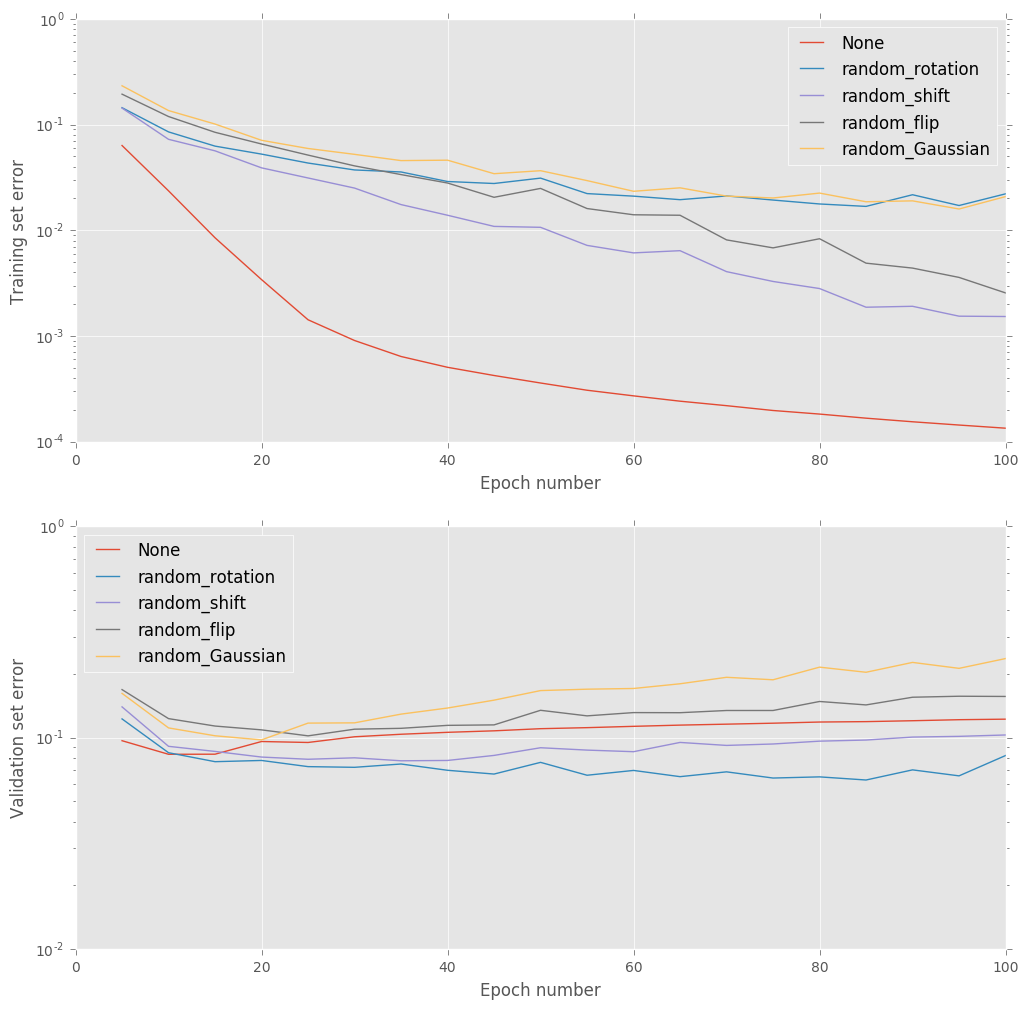

In [36]:
#define a function that can show the plot, choose info from above
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
for weight_penalty, run in run_info.items():
    stats, keys, run_time = run
    ax1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(train)']], label=str(weight_penalty))
    ax2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(valid)']], label=str(weight_penalty))

ax1.plot(np.arange(1, aug_stats1.shape[0]) * stats_interval, 
         aug_stats1[1:, aug_keys1['error(train)']], label='random_rotation')
ax2.plot(np.arange(1, aug_stats1.shape[0]) * stats_interval, 
         aug_stats1[1:, aug_keys1['error(valid)']], label='random_rotation')

ax1.plot(np.arange(1, aug_stats2.shape[0]) * stats_interval, 
         aug_stats2[1:, aug_keys2['error(train)']], label='random_shift')
ax2.plot(np.arange(1, aug_stats2.shape[0]) * stats_interval, 
         aug_stats2[1:, aug_keys2['error(valid)']], label='random_shift')

ax1.plot(np.arange(1, aug_stats3.shape[0]) * stats_interval, 
         aug_stats3[1:, aug_keys3['error(train)']], label='random_flip')
ax2.plot(np.arange(1, aug_stats3.shape[0]) * stats_interval, 
         aug_stats3[1:, aug_keys3['error(valid)']], label='random_flip')


ax1.plot(np.arange(1, aug_stats4.shape[0]) * stats_interval, 
         aug_stats4[1:, aug_keys4['error(train)']], label='random_Gaussian')
ax2.plot(np.arange(1, aug_stats4.shape[0]) * stats_interval, 
         aug_stats4[1:, aug_keys4['error(valid)']], label='random_Gaussian')

ax1.legend(loc=0)
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')
ax1.set_yscale('log')
ax2.legend(loc=0)
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set error')
ax2.set_yscale('log')

fig.savefig('sing_data_argumentation.png')

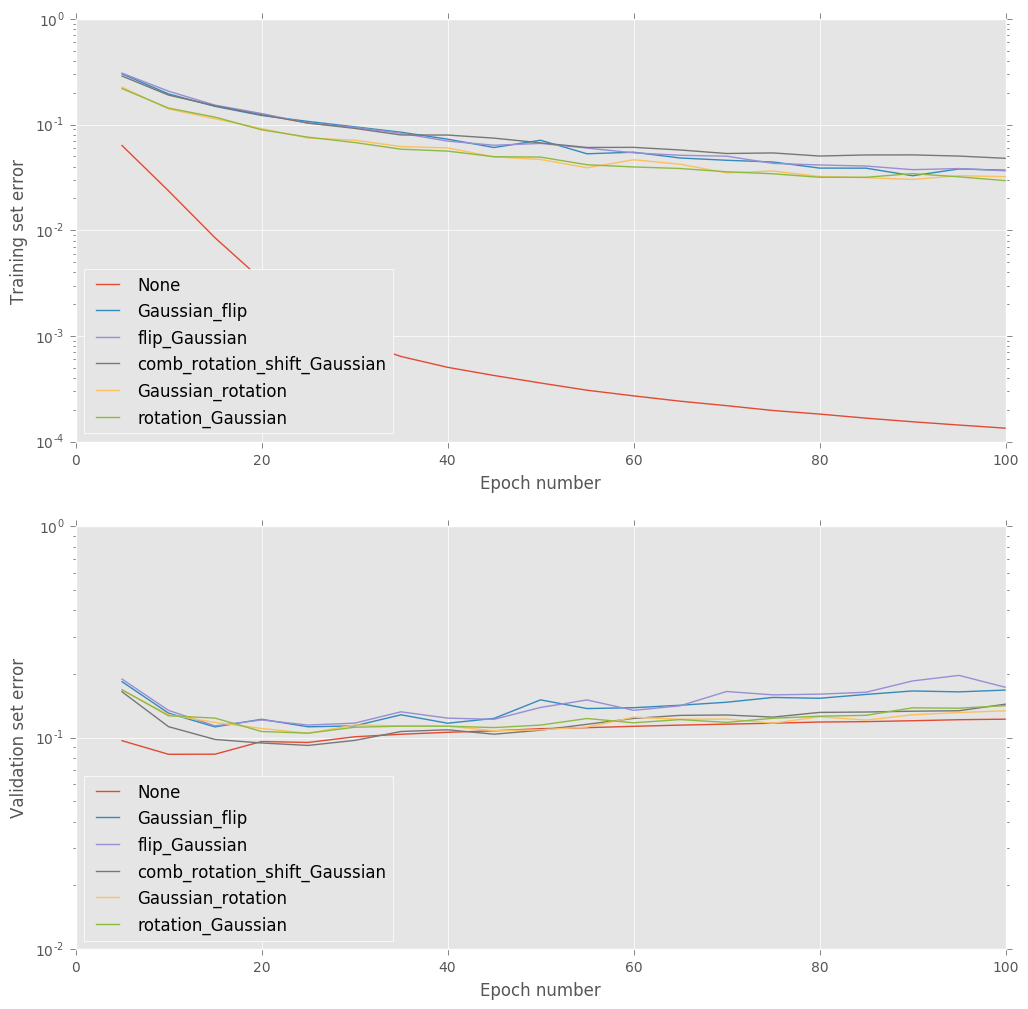

In [62]:
#define a function that can show the plot, choose info from above
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
for weight_penalty, run in run_info.items():
    stats, keys, run_time = run
    ax1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(train)']], label=str(weight_penalty))
    ax2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(valid)']], label=str(weight_penalty))

ax1.plot(np.arange(1, aug_stats5.shape[0]) * stats_interval, 
         aug_stats5[1:, aug_keys5['error(train)']], label='Gaussian_flip')
ax2.plot(np.arange(1, aug_stats5.shape[0]) * stats_interval, 
         aug_stats5[1:, aug_keys5['error(valid)']], label='Gaussian_flip')

ax1.plot(np.arange(1, aug_stats6.shape[0]) * stats_interval, 
         aug_stats6[1:, aug_keys6['error(train)']], label='flip_Gaussian')
ax2.plot(np.arange(1, aug_stats6.shape[0]) * stats_interval, 
         aug_stats6[1:, aug_keys6['error(valid)']], label='flip_Gaussian')

ax1.plot(np.arange(1, aug_stats7.shape[0]) * stats_interval, 
         aug_stats7[1:, aug_keys7['error(train)']], label='comb_rotation_shift_Gaussian')
ax2.plot(np.arange(1, aug_stats7.shape[0]) * stats_interval, 
         aug_stats7[1:, aug_keys7['error(valid)']], label='comb_rotation_shift_Gaussian')


ax1.plot(np.arange(1, aug_stats8.shape[0]) * stats_interval, 
         aug_stats8[1:, aug_keys8['error(train)']], label='Gaussian_rotation')
ax2.plot(np.arange(1, aug_stats8.shape[0]) * stats_interval, 
         aug_stats8[1:, aug_keys8['error(valid)']], label='Gaussian_rotation')

ax1.plot(np.arange(1, aug_stats9.shape[0]) * stats_interval, 
         aug_stats9[1:, aug_keys9['error(train)']], label='rotation_Gaussian')
ax2.plot(np.arange(1, aug_stats9.shape[0]) * stats_interval, 
         aug_stats9[1:, aug_keys9['error(valid)']], label='rotation_Gaussian')
ax1.legend(loc=0)
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')
ax1.set_yscale('log')
ax2.legend(loc=0)
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set error')
ax2.set_yscale('log')

fig.savefig('com_data_argumentation.png')

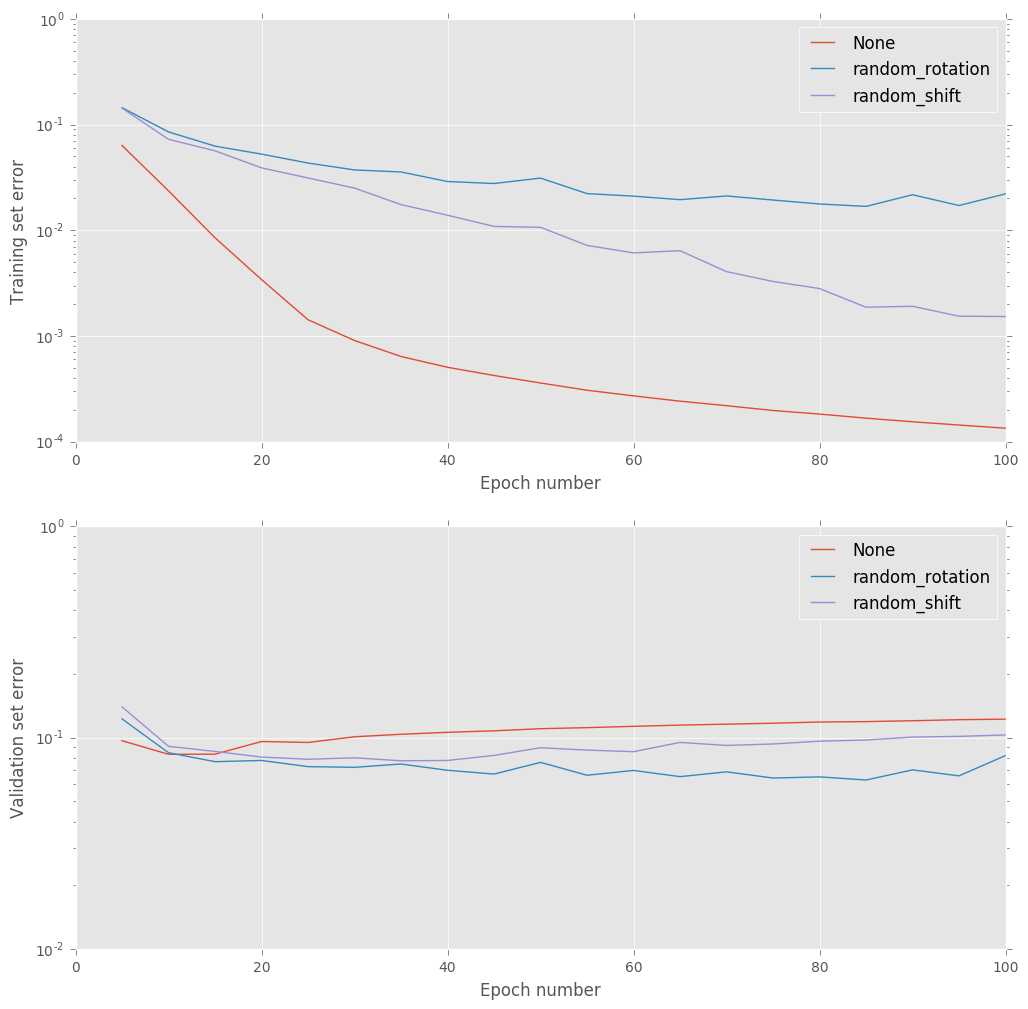

In [51]:
#define a function that can show the plot, choose info from above
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
for weight_penalty, run in run_info.items():
    stats, keys, run_time = run
    ax1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(train)']], label=str(weight_penalty))
    ax2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(valid)']], label=str(weight_penalty))

ax1.plot(np.arange(1, aug_stats1.shape[0]) * stats_interval, 
         aug_stats1[1:, aug_keys1['error(train)']], label='random_rotation')
ax2.plot(np.arange(1, aug_stats1.shape[0]) * stats_interval, 
         aug_stats1[1:, aug_keys1['error(valid)']], label='random_rotation')

ax1.plot(np.arange(1, aug_stats2.shape[0]) * stats_interval, 
         aug_stats2[1:, aug_keys2['error(train)']], label='random_shift')
ax2.plot(np.arange(1, aug_stats2.shape[0]) * stats_interval, 
         aug_stats2[1:, aug_keys2['error(valid)']], label='random_shift')

ax1.legend(loc=0)
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')
ax1.set_yscale('log')
ax2.legend(loc=0)
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set error')
ax2.set_yscale('log')

fig.savefig('better.png')

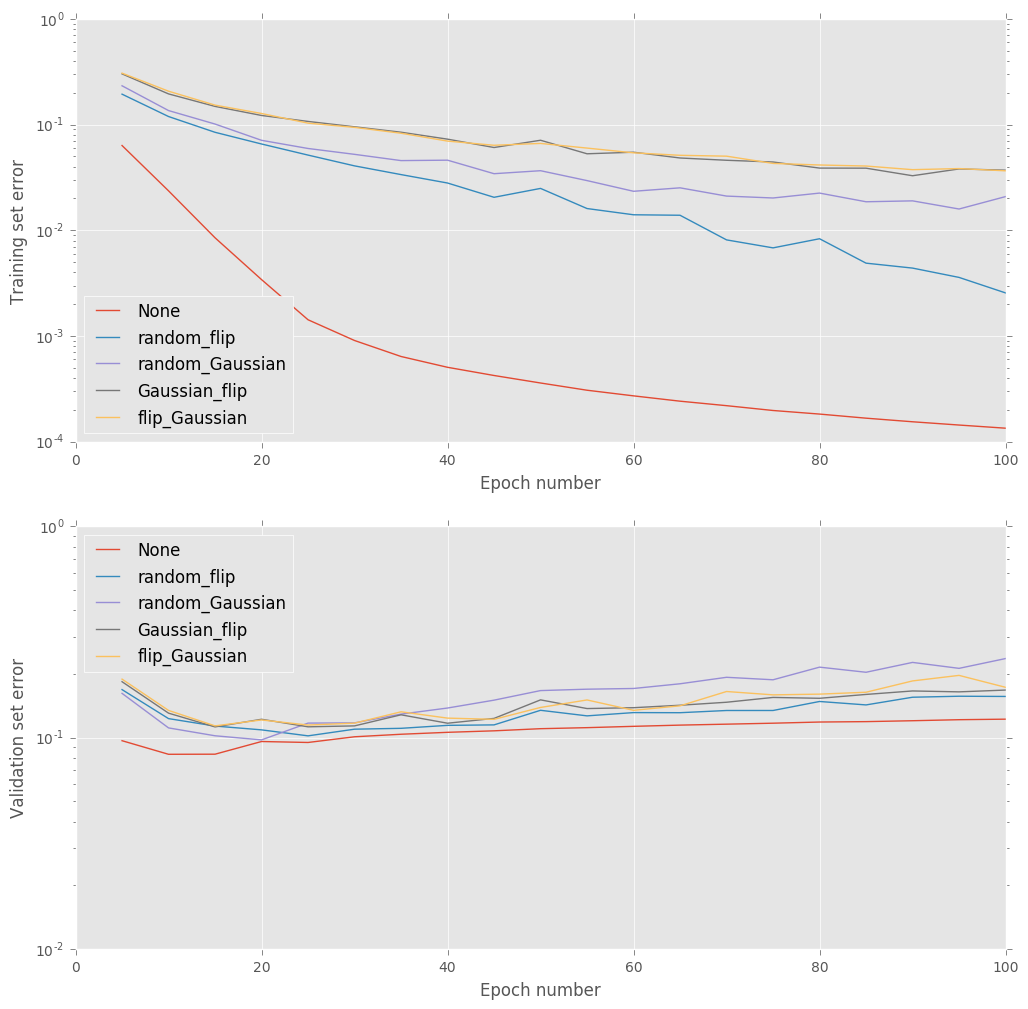

In [56]:
#define a function that can show the plot, choose info from above
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
for weight_penalty, run in run_info.items():
    stats, keys, run_time = run
    ax1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(train)']], label=str(weight_penalty))
    ax2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(valid)']], label=str(weight_penalty))

ax1.plot(np.arange(1, aug_stats3.shape[0]) * stats_interval, 
         aug_stats3[1:, aug_keys3['error(train)']], label='random_flip')
ax2.plot(np.arange(1, aug_stats3.shape[0]) * stats_interval, 
         aug_stats3[1:, aug_keys3['error(valid)']], label='random_flip')


ax1.plot(np.arange(1, aug_stats4.shape[0]) * stats_interval, 
         aug_stats4[1:, aug_keys4['error(train)']], label='random_Gaussian')
ax2.plot(np.arange(1, aug_stats4.shape[0]) * stats_interval, 
         aug_stats4[1:, aug_keys4['error(valid)']], label='random_Gaussian')

ax1.plot(np.arange(1, aug_stats5.shape[0]) * stats_interval, 
         aug_stats5[1:, aug_keys5['error(train)']], label='Gaussian_flip')
ax2.plot(np.arange(1, aug_stats5.shape[0]) * stats_interval, 
         aug_stats5[1:, aug_keys5['error(valid)']], label='Gaussian_flip')

ax1.plot(np.arange(1, aug_stats6.shape[0]) * stats_interval, 
         aug_stats6[1:, aug_keys6['error(train)']], label='flip_Gaussian')
ax2.plot(np.arange(1, aug_stats6.shape[0]) * stats_interval, 
         aug_stats6[1:, aug_keys6['error(valid)']], label='flip_Gaussian')

ax1.legend(loc=0)
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')
ax1.set_yscale('log')
ax2.legend(loc=0)
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set error')
ax2.set_yscale('log')

fig.savefig('worse.png')

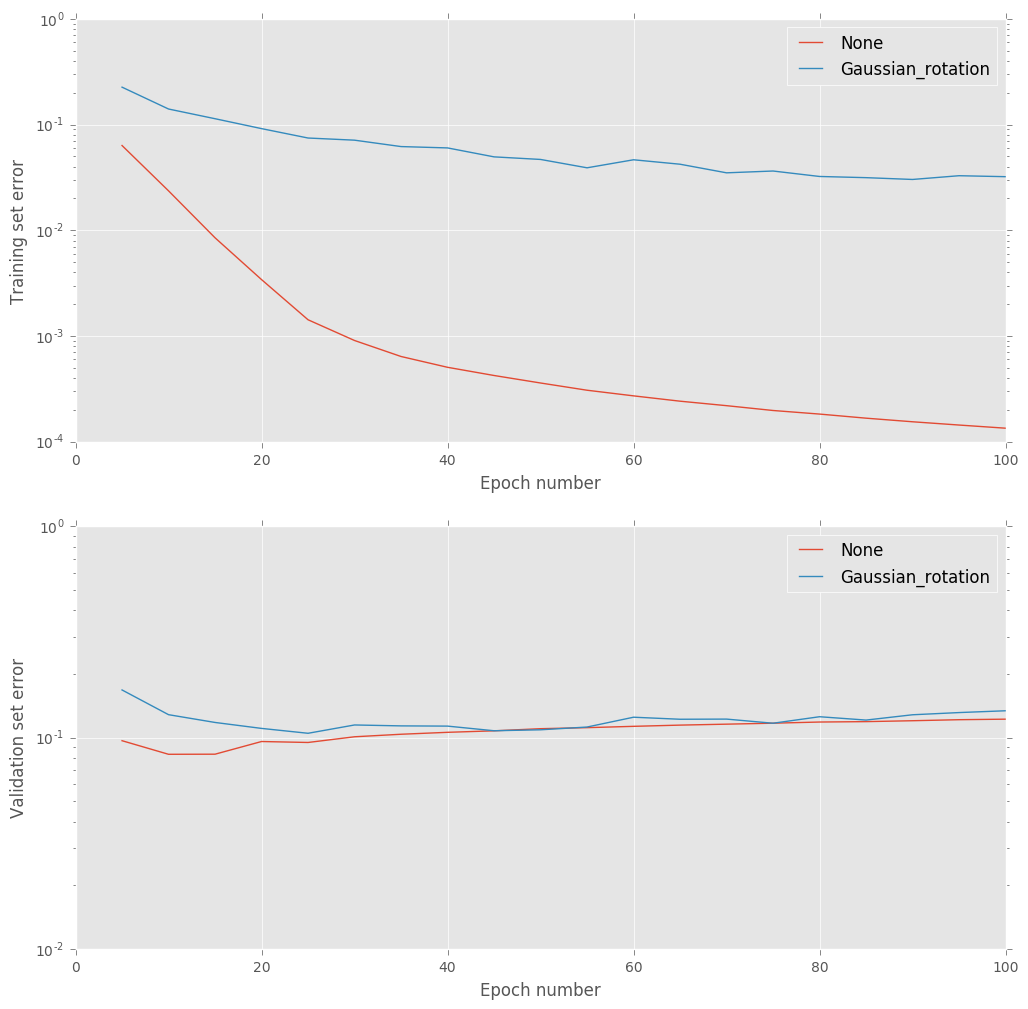

In [58]:
#define a function that can show the plot, choose info from above
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
for weight_penalty, run in run_info.items():
    stats, keys, run_time = run
    ax1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(train)']], label=str(weight_penalty))
    ax2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(valid)']], label=str(weight_penalty))

ax1.plot(np.arange(1, aug_stats8.shape[0]) * stats_interval, 
         aug_stats8[1:, aug_keys8['error(train)']], label='Gaussian_rotation')
ax2.plot(np.arange(1, aug_stats8.shape[0]) * stats_interval, 
         aug_stats8[1:, aug_keys8['error(valid)']], label='Gaussian_rotation')

ax1.legend(loc=0)
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')
ax1.set_yscale('log')
ax2.legend(loc=0)
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set error')
ax2.set_yscale('log')

fig.savefig('similar.png')

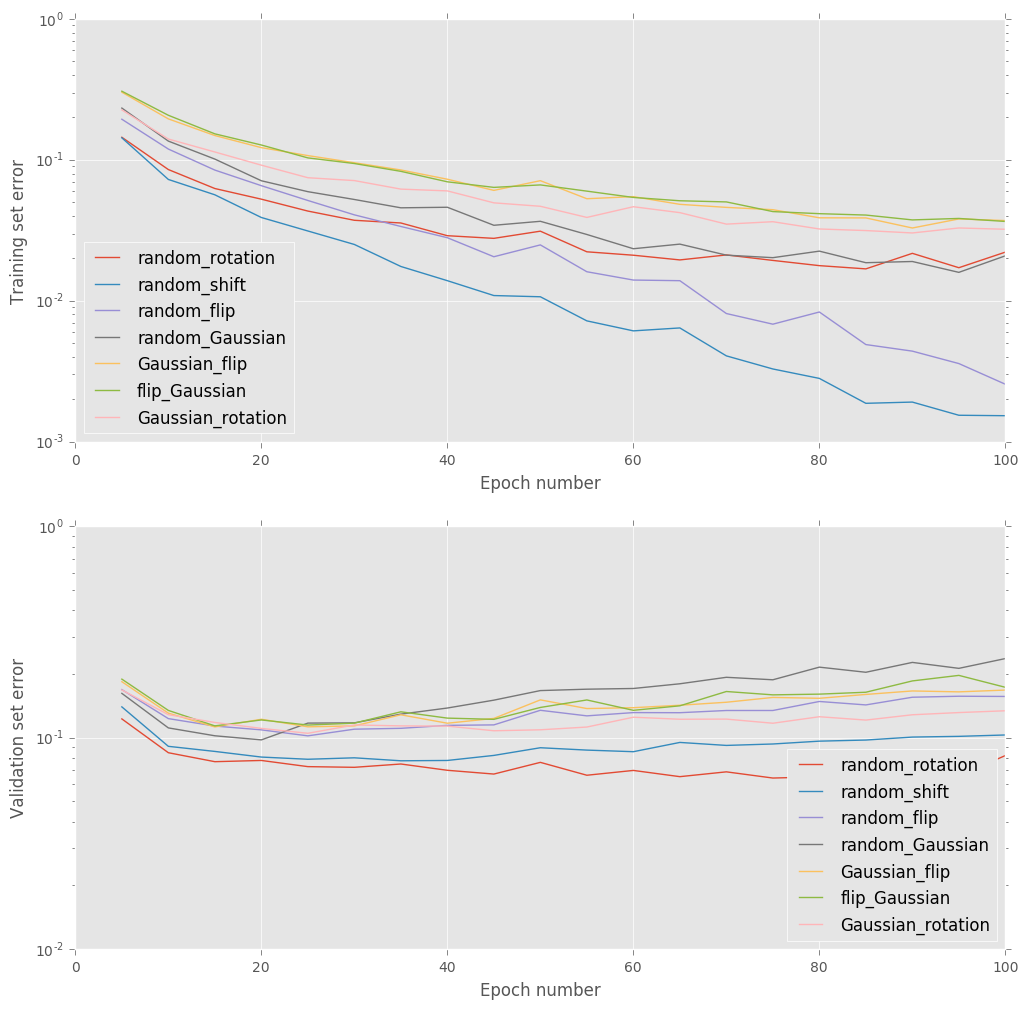

In [57]:
#define a function that can show the plot, choose info from above
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ax1.plot(np.arange(1, aug_stats1.shape[0]) * stats_interval, 
         aug_stats1[1:, aug_keys1['error(train)']], label='random_rotation')
ax2.plot(np.arange(1, aug_stats1.shape[0]) * stats_interval, 
         aug_stats1[1:, aug_keys1['error(valid)']], label='random_rotation')

ax1.plot(np.arange(1, aug_stats2.shape[0]) * stats_interval, 
         aug_stats2[1:, aug_keys2['error(train)']], label='random_shift')
ax2.plot(np.arange(1, aug_stats2.shape[0]) * stats_interval, 
         aug_stats2[1:, aug_keys2['error(valid)']], label='random_shift')

ax1.plot(np.arange(1, aug_stats3.shape[0]) * stats_interval, 
         aug_stats3[1:, aug_keys3['error(train)']], label='random_flip')
ax2.plot(np.arange(1, aug_stats3.shape[0]) * stats_interval, 
         aug_stats3[1:, aug_keys3['error(valid)']], label='random_flip')


ax1.plot(np.arange(1, aug_stats4.shape[0]) * stats_interval, 
         aug_stats4[1:, aug_keys4['error(train)']], label='random_Gaussian')
ax2.plot(np.arange(1, aug_stats4.shape[0]) * stats_interval, 
         aug_stats4[1:, aug_keys4['error(valid)']], label='random_Gaussian')

ax1.plot(np.arange(1, aug_stats5.shape[0]) * stats_interval, 
         aug_stats5[1:, aug_keys5['error(train)']], label='Gaussian_flip')
ax2.plot(np.arange(1, aug_stats5.shape[0]) * stats_interval, 
         aug_stats5[1:, aug_keys5['error(valid)']], label='Gaussian_flip')

ax1.plot(np.arange(1, aug_stats6.shape[0]) * stats_interval, 
         aug_stats6[1:, aug_keys6['error(train)']], label='flip_Gaussian')
ax2.plot(np.arange(1, aug_stats6.shape[0]) * stats_interval, 
         aug_stats6[1:, aug_keys6['error(valid)']], label='flip_Gaussian')

ax1.plot(np.arange(1, aug_stats8.shape[0]) * stats_interval, 
         aug_stats8[1:, aug_keys8['error(train)']], label='Gaussian_rotation')
ax2.plot(np.arange(1, aug_stats8.shape[0]) * stats_interval, 
         aug_stats8[1:, aug_keys8['error(valid)']], label='Gaussian_rotation')

ax1.legend(loc=0)
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')
ax1.set_yscale('log')
ax2.legend(loc=0)
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set error')
ax2.set_yscale('log')

fig.savefig('sing_and_comb.png')

In [76]:
def para_shift1(inputs, rng):
    orig_ims = inputs
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    for i, j in enumerate(indices):
        new_ims[j] = shift(orig_ims[j],shift=2.0 ,order=1)
    return new_ims.reshape((-1, 784))

def para_shift2(inputs, rng):
    orig_ims = inputs
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    for i, j in enumerate(indices):
        new_ims[j] = shift(orig_ims[j],shift=12.0 ,order=1)
    return new_ims.reshape((-1, 784))

def para_shift3(inputs, rng):
    orig_ims = inputs
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    for i, j in enumerate(indices):
        new_ims[j] = shift(orig_ims[j],shift=100.0 ,order=1)
    return new_ims.reshape((-1, 784))

def para_Gaussian1(inputs, rng):
    orig_ims = inputs.reshape((-1, 28, 28))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    for j in (indices):
        new_ims[j] = orig_ims[j]*np.random.normal(0,0.6)
    return new_ims.reshape((-1, 784))

def para_Gaussian2(inputs, rng):
    orig_ims = inputs.reshape((-1, 28, 28))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    for j in (indices):
        new_ims[j] = orig_ims[j]*np.random.normal(0,0.8)
    return new_ims.reshape((-1, 784))

In [77]:
para_train_data1 = AugmentedMNISTDataProvider('train', rng=rng, transformer=para_shift1)
para_train_data2 = AugmentedMNISTDataProvider('train', rng=rng, transformer=para_shift2)
para_train_data3 = AugmentedMNISTDataProvider('train', rng=rng, transformer=para_Gaussian1)
para_train_data4 = AugmentedMNISTDataProvider('train', rng=rng, transformer=para_Gaussian2)
para_train_data5 = AugmentedMNISTDataProvider('train', rng=rng, transformer=para_shift3)

In [65]:
batch_size = 100
num_epochs = 100
learning_rate = 0.01
mom_coeff = 0.9
stats_interval = 5

rng.seed(seed)
para_train_data1.reset()
valid_data.reset()
para_train_data1.batch_size = batch_size 
valid_data.batch_size = batch_size

weights_init = GlorotUniformInit(0.5, rng=rng)
biases_init = ConstantInit(0.)

model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
learning_rule = MomentumLearningRule(learning_rate=learning_rate, mom_coeff=mom_coeff)
data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
optimiser = Optimiser(
    model, error, learning_rule, para_train_data1, valid_data, data_monitors)

para_aug_stats1, para_aug_keys1, para_aug_run_time1 = optimiser.train(
    num_epochs=num_epochs, stats_interval=stats_interval)

Epoch 5: 2.38s to complete
  error(train)=1.43e-01, acc(train)=9.57e-01, error(valid)=1.40e-01, acc(valid)=9.59e-01, params_penalty=0.00e+00
Epoch 10: 2.88s to complete
  error(train)=7.26e-02, acc(train)=9.79e-01, error(valid)=9.09e-02, acc(valid)=9.74e-01, params_penalty=0.00e+00
Epoch 15: 2.54s to complete
  error(train)=5.65e-02, acc(train)=9.83e-01, error(valid)=8.60e-02, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 20: 3.01s to complete
  error(train)=3.90e-02, acc(train)=9.89e-01, error(valid)=8.09e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 25: 2.65s to complete
  error(train)=3.13e-02, acc(train)=9.91e-01, error(valid)=7.90e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 30: 3.37s to complete
  error(train)=2.51e-02, acc(train)=9.93e-01, error(valid)=8.02e-02, acc(valid)=9.79e-01, params_penalty=0.00e+00
Epoch 35: 2.49s to complete
  error(train)=1.75e-02, acc(train)=9.96e-01, error(valid)=7.77e-02, acc(valid)=9.79e-01, params_penalty=0.00e+00
Epoch 4

In [66]:
batch_size = 100
num_epochs = 100
learning_rate = 0.01
mom_coeff = 0.9
stats_interval = 5

rng.seed(seed)
para_train_data2.reset()
valid_data.reset()
para_train_data2.batch_size = batch_size 
valid_data.batch_size = batch_size

weights_init = GlorotUniformInit(0.5, rng=rng)
biases_init = ConstantInit(0.)

model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
learning_rule = MomentumLearningRule(learning_rate=learning_rate, mom_coeff=mom_coeff)
data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
optimiser = Optimiser(
    model, error, learning_rule, para_train_data2, valid_data, data_monitors)

para_aug_stats2, para_aug_keys2, para_aug_run_time2 = optimiser.train(
    num_epochs=num_epochs, stats_interval=stats_interval)

Epoch 5: 2.35s to complete
  error(train)=1.59e-01, acc(train)=9.53e-01, error(valid)=1.49e-01, acc(valid)=9.57e-01, params_penalty=0.00e+00
Epoch 10: 2.33s to complete
  error(train)=8.78e-02, acc(train)=9.74e-01, error(valid)=1.01e-01, acc(valid)=9.71e-01, params_penalty=0.00e+00
Epoch 15: 2.29s to complete
  error(train)=6.38e-02, acc(train)=9.81e-01, error(valid)=9.09e-02, acc(valid)=9.74e-01, params_penalty=0.00e+00
Epoch 20: 2.37s to complete
  error(train)=4.43e-02, acc(train)=9.87e-01, error(valid)=8.52e-02, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 25: 2.19s to complete
  error(train)=3.51e-02, acc(train)=9.90e-01, error(valid)=8.72e-02, acc(valid)=9.75e-01, params_penalty=0.00e+00
Epoch 30: 2.21s to complete
  error(train)=2.21e-02, acc(train)=9.94e-01, error(valid)=8.27e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 35: 2.21s to complete
  error(train)=1.86e-02, acc(train)=9.96e-01, error(valid)=9.05e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 4

In [67]:
batch_size = 100
num_epochs = 100
learning_rate = 0.01
mom_coeff = 0.9
stats_interval = 5

rng.seed(seed)
para_train_data3.reset()
valid_data.reset()
para_train_data3.batch_size = batch_size 
valid_data.batch_size = batch_size

weights_init = GlorotUniformInit(0.5, rng=rng)
biases_init = ConstantInit(0.)

model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
learning_rule = MomentumLearningRule(learning_rate=learning_rate, mom_coeff=mom_coeff)
data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
optimiser = Optimiser(
    model, error, learning_rule, para_train_data3, valid_data, data_monitors)

para_aug_stats3, para_aug_keys3, para_aug_run_time3 = optimiser.train(
    num_epochs=num_epochs, stats_interval=stats_interval)

Epoch 5: 0.97s to complete
  error(train)=2.64e-01, acc(train)=9.37e-01, error(valid)=1.73e-01, acc(valid)=9.52e-01, params_penalty=0.00e+00
Epoch 10: 0.97s to complete
  error(train)=1.48e-01, acc(train)=9.68e-01, error(valid)=1.09e-01, acc(valid)=9.70e-01, params_penalty=0.00e+00
Epoch 15: 0.98s to complete
  error(train)=1.12e-01, acc(train)=9.73e-01, error(valid)=1.09e-01, acc(valid)=9.72e-01, params_penalty=0.00e+00
Epoch 20: 0.99s to complete
  error(train)=8.14e-02, acc(train)=9.82e-01, error(valid)=1.03e-01, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 25: 1.09s to complete
  error(train)=6.75e-02, acc(train)=9.88e-01, error(valid)=1.18e-01, acc(valid)=9.74e-01, params_penalty=0.00e+00
Epoch 30: 0.98s to complete
  error(train)=5.60e-02, acc(train)=9.89e-01, error(valid)=1.19e-01, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 35: 0.98s to complete
  error(train)=4.54e-02, acc(train)=9.92e-01, error(valid)=1.30e-01, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 4

In [68]:
batch_size = 100
num_epochs = 100
learning_rate = 0.01
mom_coeff = 0.9
stats_interval = 5

rng.seed(seed)
para_train_data4.reset()
valid_data.reset()
para_train_data4.batch_size = batch_size 
valid_data.batch_size = batch_size

weights_init = GlorotUniformInit(0.5, rng=rng)
biases_init = ConstantInit(0.)

model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
learning_rule = MomentumLearningRule(learning_rate=learning_rate, mom_coeff=mom_coeff)
data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
optimiser = Optimiser(
    model, error, learning_rule, para_train_data4, valid_data, data_monitors)

para_aug_stats4, para_aug_keys4, para_aug_run_time4 = optimiser.train(
    num_epochs=num_epochs, stats_interval=stats_interval)

Epoch 5: 0.98s to complete
  error(train)=2.36e-01, acc(train)=9.43e-01, error(valid)=1.61e-01, acc(valid)=9.56e-01, params_penalty=0.00e+00
Epoch 10: 0.99s to complete
  error(train)=1.41e-01, acc(train)=9.67e-01, error(valid)=1.05e-01, acc(valid)=9.72e-01, params_penalty=0.00e+00
Epoch 15: 0.99s to complete
  error(train)=1.07e-01, acc(train)=9.76e-01, error(valid)=1.01e-01, acc(valid)=9.74e-01, params_penalty=0.00e+00
Epoch 20: 1.00s to complete
  error(train)=7.47e-02, acc(train)=9.84e-01, error(valid)=9.93e-02, acc(valid)=9.75e-01, params_penalty=0.00e+00
Epoch 25: 1.00s to complete
  error(train)=6.20e-02, acc(train)=9.89e-01, error(valid)=1.13e-01, acc(valid)=9.73e-01, params_penalty=0.00e+00
Epoch 30: 1.07s to complete
  error(train)=4.60e-02, acc(train)=9.92e-01, error(valid)=1.11e-01, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 35: 1.03s to complete
  error(train)=4.21e-02, acc(train)=9.92e-01, error(valid)=1.24e-01, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 4

In [78]:
batch_size = 100
num_epochs = 100
learning_rate = 0.01
mom_coeff = 0.9
stats_interval = 5

rng.seed(seed)
para_train_data5.reset()
valid_data.reset()
para_train_data5.batch_size = batch_size 
valid_data.batch_size = batch_size

weights_init = GlorotUniformInit(0.5, rng=rng)
biases_init = ConstantInit(0.)

model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
learning_rule = MomentumLearningRule(learning_rate=learning_rate, mom_coeff=mom_coeff)
data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
optimiser = Optimiser(
    model, error, learning_rule, para_train_data5, valid_data, data_monitors)

para_aug_stats5, para_aug_keys5, para_aug_run_time5 = optimiser.train(
    num_epochs=num_epochs, stats_interval=stats_interval)

Epoch 5: 2.56s to complete
  error(train)=1.61e-01, acc(train)=9.51e-01, error(valid)=1.50e-01, acc(valid)=9.58e-01, params_penalty=0.00e+00
Epoch 10: 2.18s to complete
  error(train)=8.23e-02, acc(train)=9.76e-01, error(valid)=9.93e-02, acc(valid)=9.72e-01, params_penalty=0.00e+00
Epoch 15: 2.20s to complete
  error(train)=6.27e-02, acc(train)=9.81e-01, error(valid)=9.31e-02, acc(valid)=9.74e-01, params_penalty=0.00e+00
Epoch 20: 2.18s to complete
  error(train)=3.96e-02, acc(train)=9.89e-01, error(valid)=8.55e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 25: 2.19s to complete
  error(train)=3.19e-02, acc(train)=9.91e-01, error(valid)=9.34e-02, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 30: 2.21s to complete
  error(train)=2.25e-02, acc(train)=9.94e-01, error(valid)=9.15e-02, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 35: 2.23s to complete
  error(train)=1.93e-02, acc(train)=9.95e-01, error(valid)=9.61e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 4

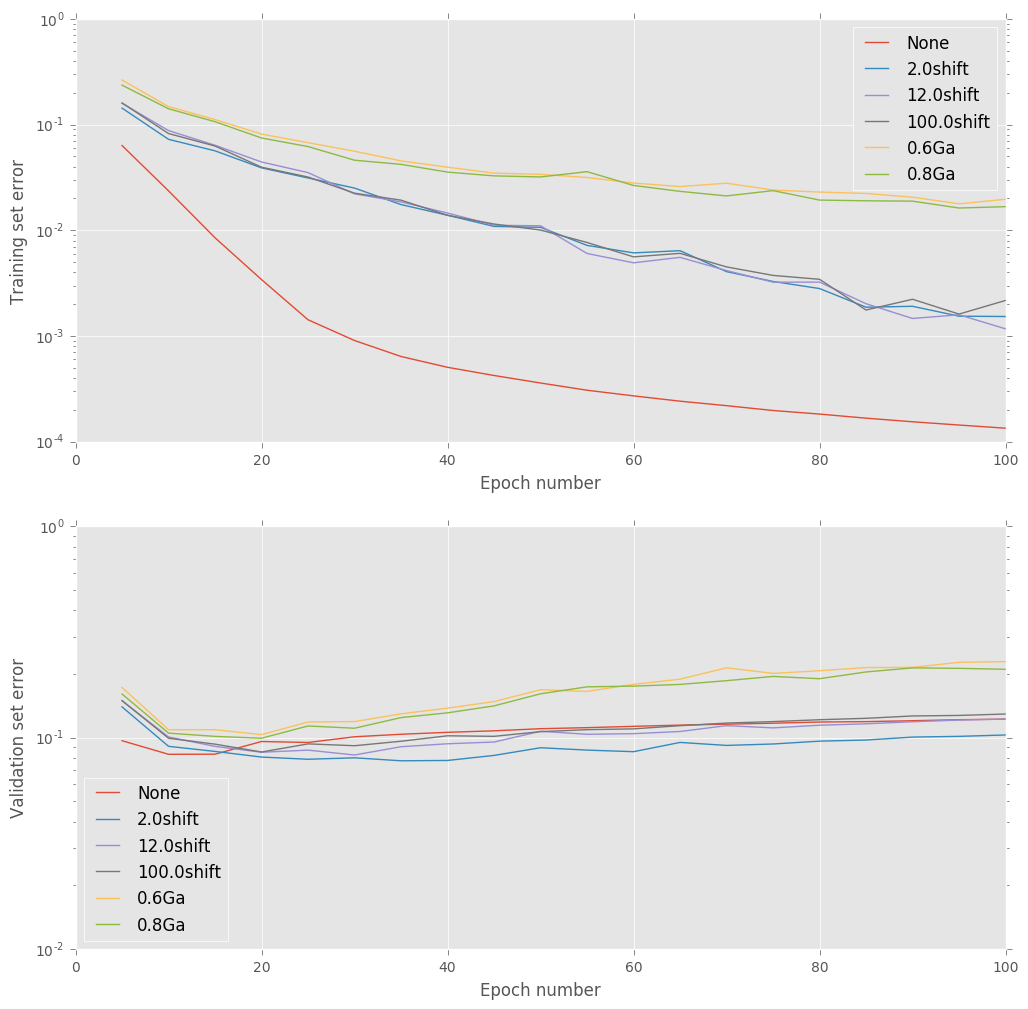

In [80]:
#define a function that can show the plot, choose info from above
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
for weight_penalty, run in run_info.items():
    stats, keys, run_time = run
    ax1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(train)']], label=str(weight_penalty))
    ax2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(valid)']], label=str(weight_penalty))

ax1.plot(np.arange(1, para_aug_stats1.shape[0]) * stats_interval, 
         para_aug_stats1[1:, para_aug_keys1['error(train)']], label='2.0shift')
ax2.plot(np.arange(1, para_aug_stats1.shape[0]) * stats_interval, 
         para_aug_stats1[1:, para_aug_keys1['error(valid)']], label='2.0shift')

ax1.plot(np.arange(1, para_aug_stats2.shape[0]) * stats_interval, 
         para_aug_stats2[1:, para_aug_keys2['error(train)']], label='12.0shift')
ax2.plot(np.arange(1, para_aug_stats2.shape[0]) * stats_interval, 
         para_aug_stats2[1:, para_aug_keys2['error(valid)']], label='12.0shift')

ax1.plot(np.arange(1, para_aug_stats5.shape[0]) * stats_interval, 
         para_aug_stats5[1:, para_aug_keys5['error(train)']], label='100.0shift')
ax2.plot(np.arange(1, para_aug_stats5.shape[0]) * stats_interval, 
         para_aug_stats5[1:, para_aug_keys5['error(valid)']], label='100.0shift')

ax1.plot(np.arange(1, para_aug_stats3.shape[0]) * stats_interval, 
         para_aug_stats3[1:, para_aug_keys3['error(train)']], label='0.6Ga')
ax2.plot(np.arange(1, para_aug_stats3.shape[0]) * stats_interval, 
         para_aug_stats3[1:, para_aug_keys3['error(valid)']], label='0.6Ga')

ax1.plot(np.arange(1, para_aug_stats4.shape[0]) * stats_interval, 
         para_aug_stats4[1:, para_aug_keys4['error(train)']], label='0.8Ga')
ax2.plot(np.arange(1, para_aug_stats4.shape[0]) * stats_interval, 
         para_aug_stats4[1:, para_aug_keys4['error(valid)']], label='0.8Ga')

ax1.legend(loc=0)
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')
ax1.set_yscale('log')
ax2.legend(loc=0)
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set error')
ax2.set_yscale('log')

fig.savefig('paracom.png')